# Homework5: Wasserstein GAN

Быкова Ульяна

I've changed the format of data a little bit according to this link (https://github.com/soumith/ganhacks/blob/master/README.md)

## Task 1: Theory (4pt)

### Problem 1: Importance weighted dequantization (1pt)
Let's recall the variational lower bound for the discrete data dequantization from Lecture 7:
$$
    \log P(\mathbf{y} | \boldsymbol{\theta}) \geq  \int q(\mathbf{u} | \mathbf{y}) \log \frac{p(\mathbf{y} + \mathbf{u} | \boldsymbol{\theta})}{q(\mathbf{u} | \mathbf{y})} d \mathbf{u} = \mathcal{L}(q, \boldsymbol{\theta}).
$$
Previously we have discussed (Lecture 4, IWAE) that the variational lower bound can be improved with the help of Importance Sampling technique. Write out the lower bound for dequantization using $\mathcal{L}_k$ by analogy with the IWAE model.

$$\mathcal{L}_k (q, \boldsymbol{\theta}) = \mathbb{E}_{q(\mathbf{u} | \mathbf{y}) } \left[\log \frac{p(\mathbf{y} + \mathbf{u} | \boldsymbol{\theta})}{q(\mathbf{u}| \mathbf{y})} \right] \le \log\mathbb{E}_{q(\mathbf{u} | \mathbf{y})} \left[ \frac{p(\mathbf{y} + \mathbf{u} | \boldsymbol{\theta})}{q(\mathbf{u}| \mathbf{y})} \right] = \log \left[ \frac{1}{K}\sum_{k=1}^K\frac{p(\mathbf{y} + \mathbf{u}_k | \boldsymbol{\theta})}{q(\mathbf{u}_k| \mathbf{y})} \right]  = \log P(\mathbf{y} | \boldsymbol{\theta})$$

## Task 2: Wasserstein GANs for CIFAR 10 (9pt)

In this task you will fit different kinds of Wasserstein GANs (different ways to enforce Lipschitzness) that we discussed in the Lectures 9 and 10 to the CIFAR10 dataset
* [WGAN](https://arxiv.org/abs/1701.07875) - standard Wasserstein GAN with weight clipping;
* [WGAN-GP](https://arxiv.org/pdf/1704.00028.pdf) - Wasserstein GAN with Gradient Penalty;
* [SN-GAN](https://arxiv.org/pdf/1802.05957.pdf) - Wasserstein GAN with Spectral Normalization.


Download the data from [here](https://drive.google.com/file/d/1FZcV8Mm91fiXm2jFnB0jvK5ROyHdJFvj/view?usp=sharing) (you could use the cell below).

### Libraries and data

In [3]:
# REPO_NAME = "2022-2023-DGM-AIMasters-course"
# !if [ -d {REPO_NAME} ]; then rm -Rf {REPO_NAME}; fi
# !git clone https://github.com/r-isachenko/{REPO_NAME}.git
# !cd {REPO_NAME}
# !pip install ./{REPO_NAME}/homeworks/
# !rm -Rf {REPO_NAME}

In [4]:
from dgm_utils import show_samples, visualize_images, load_pickle 

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
from enum import Enum
from functools import partial
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.distributions as TD

USE_CUDA = torch.cuda.is_available()

print('cuda is available:', USE_CUDA)

cuda is available: True


In [6]:
# from google.colab import drive
# drive.mount('/content/drive')

In [7]:
# do not change this function
def plot_losses(losses, title):
    n_itr = len(losses)
    xs = np.arange(n_itr)

    plt.figure(figsize=(7, 5))
    plt.plot(xs, losses)
    plt.title(title, fontsize=14)
    plt.xlabel('Iterations', fontsize=14)
    plt.ylabel('Loss', fontsize=14)

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

In [8]:
# !gdown 1FZcV8Mm91fiXm2jFnB0jvK5ROyHdJFvj

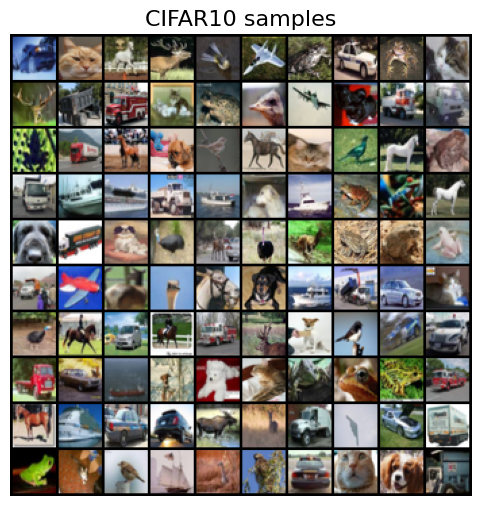

In [9]:
# train_data, test_data = load_pickle('/content/cifar10.pkl')
train_data, test_data = load_pickle('cifar10.pkl')
visualize_images(train_data, 'CIFAR10 samples')

In [10]:
train_data, test_data = (train_data * 2) - 1, (test_data * 2) - 1

### Problem 1: WGAN (3pt)

[WGAN](https://arxiv.org/abs/1701.07875) model uses weight clipping to enforce Lipschitzness of the critic.

The model objective is
$$
\min_{G} W(\pi || p) \approx \min_{G} \max_{\boldsymbol{\phi} \in \boldsymbol{\Phi}} \left[ \mathbb{E}_{\pi(\mathbf{x})} f(\mathbf{x}, \boldsymbol{\phi})  - \mathbb{E}_{p(\mathbf{z})} f(G(\mathbf{z}, \boldsymbol{\theta}), \boldsymbol{\phi} )\right].
$$
Here $f(\mathbf{x}, \boldsymbol{\phi})$ is the critic model. The critic weights $\boldsymbol{\phi}$ should lie in the compact set $\boldsymbol{\Phi} = [-c, c]^d$.

In this task we will use fully-connected networks for the generator $G(\mathbf{z}, \boldsymbol{\theta})$ and the critic $f(\mathbf{x}, \boldsymbol{\phi})$.

Here we will use convolution-based generator and critic.

First of all, let define generator network. It will be the same for all WGAN models.

In [11]:
class PrintLayer(nn.Module):
    def __init__(self):
        super(PrintLayer, self).__init__()
    
    def forward(self, x):
        print(x.shape)
        return x

In [12]:
class PrintLayer2(nn.Module):
    def __init__(self):
        super(PrintLayer, self).__init__()
    
    def forward(self, x):
        print(x)
        return x

In [13]:
# https://discuss.pytorch.org/t/how-to-build-a-view-layer-in-pytorch-for-sequential-models/53958/11

class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape

    def __repr__(self):
        return f'View{self.shape}'

    def forward(self, input_):
        '''
        Reshapes the input according to the shape saved in the view data structure.
        '''
        out = input_.view(*self.shape)
        return out

In [14]:
class ConvGenerator(nn.Module):
    def __init__(self, input_size=128, n_channels=64):
        super().__init__()
        self.n_channels = n_channels
        self.input_size = input_size
        # ====
        # 1) define linear layer with output units 4 * 4 * 4 * n_channels, then relu
        # 2) define transposed conv with stride 2, kernel size 2 then BN, then relu
        # 3) define transposed conv with stride 2, kernel size 2 then BN, then relu
        self.linear = nn.Sequential(nn.Linear(input_size, 4 * 4 * 4 * n_channels),
                                    nn.ReLU(inplace=True)
                                   )
        transposed_conv = []
        
        transposed_conv.extend([
                                nn.ConvTranspose2d(4 * n_channels, 2 * n_channels, stride=2, kernel_size=2),
                                nn.BatchNorm2d(2 * n_channels, momentum=0.9),
                                nn.ReLU(inplace=True)
        ])
        
        transposed_conv.extend([nn.ConvTranspose2d(2 * n_channels, n_channels, stride=2, kernel_size=2),
                                #nn.Dropout2d(inplace=True),
                                nn.BatchNorm2d(n_channels, momentum=0.9),
                                nn.ReLU(inplace=True)
                               ])
        
        transposed_conv.extend([nn.ConvTranspose2d(n_channels, 3, stride=2, kernel_size=2),
                                nn.BatchNorm2d(3, momentum=0.9),
                                nn.Tanh()])
        
        self.transposed_conv = nn.Sequential(*transposed_conv)

        # ====

    def forward(self, input_):
        # ====
        # apply all layers
        output = self.linear(input_).view(-1, 4 * self.n_channels, 4, 4)
        output = self.transposed_conv(output)

        # ====
        return output.view(-1, 3, 32, 32)
#         return (output.view(-1, 3, 32, 32) + 1) / 2

    def sample(self, n_samples):
        # ====
        # sample from standard normal distribution and apply the model
#         prior = torch.distributions.Normal(torch.zeros(self.input_size),
#                                            torch.ones(self.input_size))
        prior = torch.distributions.Uniform(-torch.ones(self.input_size),
                                           torch.ones(self.input_size))
        samples = prior.sample((n_samples,)).cuda() if USE_CUDA else prior.sample((n_samples,))
        samples = self.forward(samples)
        return samples
        # ====

Now it is time to define our critic. Here we will use the same class for all WGAN models, but the arguments will depend on the WGAN mode.

In [15]:
class ConvCritic(nn.Module):
    def __init__(self, n_channels, conv_layer=None, linear_layer=None, clip_c=None):
        super().__init__()
        self.n_channels = n_channels
        self.conv_layer = conv_layer or nn.Conv2d
        self.linear_layer = linear_layer or nn.Linear
        self.clip_c = clip_c
        
        # ====
        # sequence of convolutional layers and LeakyRelU -> reshape -> FC
        # !Note:! use self.conv_layer and self.linear_layer 
        # (it is important for the SN-GAN model)
        
        net = []
        net.extend([self.conv_layer(3, n_channels, kernel_size=3, stride=2),
                    nn.LeakyReLU(inplace=True),
                    self.conv_layer(n_channels, 2 * n_channels, kernel_size=3, stride=2),
                    nn.LeakyReLU(inplace=True),
                    self.conv_layer(2 * n_channels, 4 * n_channels, kernel_size=3, stride=2),
                    nn.LeakyReLU(inplace=True),
                    self.conv_layer(4 * n_channels, 8 * n_channels, kernel_size=3, stride=2),
                    View((-1,4 * 4 * 4 * n_channels)),
                    self.linear_layer(4 * 4 * 4 * n_channels, 1)
                   ])
        
        self.net = nn.Sequential(*net)

        # ====
        
    def clip_weights(self):
        for layer in self.net:
            if isinstance(layer, nn.Linear) or isinstance(layer, nn.Conv2d):
                # ====
                # clip the weight to the range [-clip_c, clip_c]
                weight = torch.clip(layer.weight.data, min=-self.clip_c, max=self.clip_c)
                # ====
                layer.weight.data = weight
            

    def forward(self, x):
        # ====
        # 1) clip the critic weights (if clip_c is given)
        # 2) apply all layers
        if self.clip_c:
            self.clip_weights()
        output = self.net(x)
        # ====
        return output

In [16]:
def train_wgan(
    generator, 
    critic, 
    train_loader,
    critic_steps, 
    batch_size,
    n_epochs,
    lr, 
    use_cuda=False,
    gp_weight=None
):

    if use_cuda:
        critic = critic.cuda()
        generator = generator.cuda()
    critic.train()
    generator.train()

    gen_optimizer = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0, 0.9))
    critic_optimizer = torch.optim.Adam(critic.parameters(), lr=lr, betas=(0, 0.9))

    curr_iter = 0
    d_loss, g_loss = torch.zeros(1), torch.zeros(1)
    batch_loss_history = {'discriminator_losses': [], 'generator_losses': []}
    for epoch_i in tqdm(range(n_epochs)):
        for batch_i, x in enumerate(train_loader):
            curr_iter += 1
            if use_cuda:
                x = x.cuda()

            # do a critic update
            critic_optimizer.zero_grad()
            fake_data = generator.sample(x.shape[0])

            # ====
            # D(x_fake) - D(x_real)
            d_loss = critic(fake_data).mean() - critic(x).mean()

            # ====

            if gp_weight is not None:
                gp = gradient_penalty(critic, x, fake_data)
                d_loss += gp_weight * gp

            d_loss.backward()
            critic_optimizer.step()
#             torch.nn.utils.clip_grad_norm_(parameters=critic.parameters(), max_norm=5, norm_type=2.0)

            # generator update
            if curr_iter % critic_steps == 0:
                gen_optimizer.zero_grad()
                fake_data = generator.sample(batch_size)
                # ====
                # -D(x_fake)
                g_loss = -critic(fake_data).mean()
                # ====
                g_loss.backward()
                gen_optimizer.step()
                
#                 torch.nn.utils.clip_grad_norm_(parameters=generator.parameters(), max_norm=5, norm_type=2.0)
                
                batch_loss_history['generator_losses'].append(g_loss.data.cpu().numpy())
                batch_loss_history['discriminator_losses'].append(d_loss.data.cpu().numpy())
#                 print('Critic')            
#                 for p in critic.parameters():
#                     print(p.grad.norm())
#                 print('Generator') 
#                 for p in generator.parameters():
#                     print(p.grad.norm())

    return batch_loss_history

In [166]:
# for p in list(filter(lambda p: p.grad is not None, generator.parameters())):
#     print(p.grad.data.norm(2).item())

  0%|          | 0/20 [00:00<?, ?it/s]

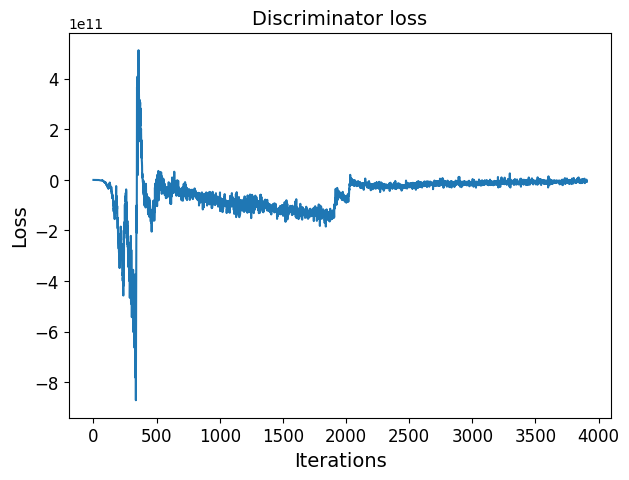

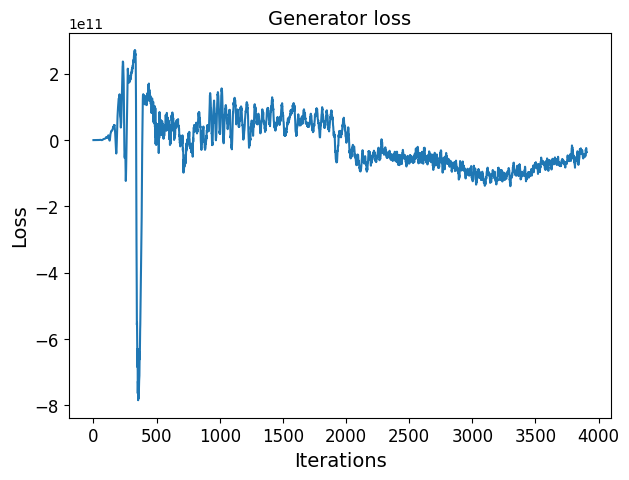

In [186]:
# ====
# choose these parameters (you have to train the model more than 20 epochs to get good results)
BATCH_SIZE = 16   # any adequate value
N_CHANNELS = 64   # > 32
N_EPOCHS = 20     # > 10
CRITIC_STEPS = 16 # > 2
CLIP_C = 0.05       # < 1
LR = 3e-4           # < 1e-3
# ====

train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

generator = ConvGenerator(n_channels=N_CHANNELS)
critic = ConvCritic(n_channels=N_CHANNELS, clip_c=CLIP_C)

train_losses = train_wgan(
    generator, 
    critic, 
    train_loader,
    critic_steps=CRITIC_STEPS, 
    batch_size=BATCH_SIZE, 
    n_epochs=N_EPOCHS,
    lr=LR,
    use_cuda=USE_CUDA
)

plot_losses(train_losses['discriminator_losses'], 'Discriminator loss')
plot_losses(train_losses['generator_losses'], 'Generator loss')

Let sample from our model and draw the samples.

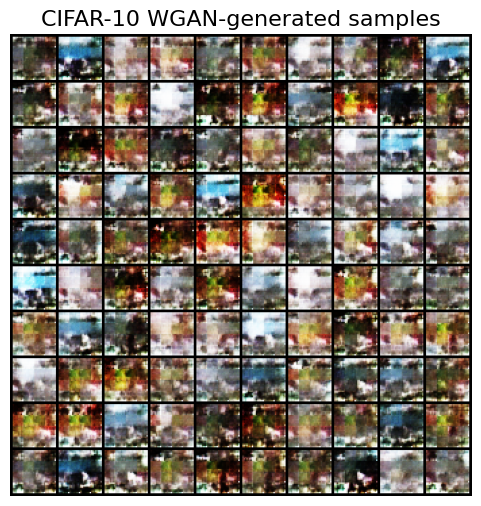

In [185]:
# clip 0.5

generator.eval()
critic.eval()
with torch.no_grad():
    samples = generator.sample(1000)
    samples = samples.cpu().detach().numpy()
    
samples = (samples + 1) / 2
show_samples(samples[:100], title='CIFAR-10 WGAN-generated samples')

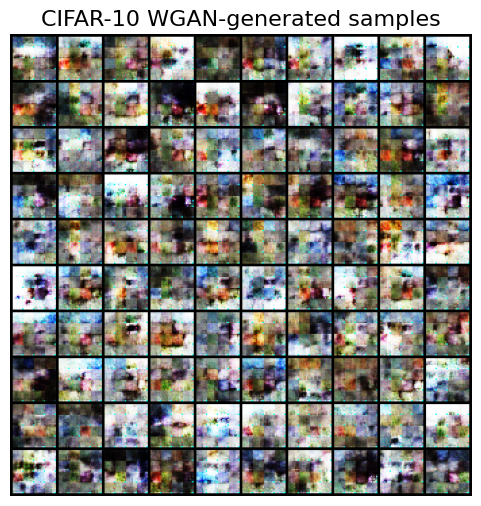

In [173]:
generator.eval()
critic.eval()
with torch.no_grad():
    samples = generator.sample(1000)
    samples = samples.cpu().detach().numpy()
    
samples = (samples + 1) / 2
show_samples(samples[:100], title='CIFAR-10 WGAN-generated samples')

### Problem 2: WGAN-GP for CIFAR 10 (3pt)

[WGAN-GP](https://arxiv.org/pdf/1704.00028.pdf)  model uses gradient penalty to enforce Lipschitzness.

The model objective is
$$
    W(\pi || p) = \underbrace{\mathbb{E}_{\pi(\mathbf{x})} f(\mathbf{x})  - \mathbb{E}_{p(\mathbf{x} | \boldsymbol{\theta})} f(\mathbf{x})}_{\text{original critic loss}} + \lambda \underbrace{\mathbb{E}_{U[0, 1]} \left[ \left( \| \nabla_{\hat{\mathbf{x}}} f(\hat{\mathbf{x}}) \|_2 - 1 \right) ^ 2\right]}_{\text{gradient penalty}},
$$
where the samples $\hat{\mathbf{x}}_t = t \mathbf{x} + (1 - t) \mathbf{y}$ with $t \in [0, 1]$ are uniformly sampled along straight lines between pairs of points: $\mathbf{x}$ from the data distribution $\pi(\mathbf{x})$ and $\mathbf{y}$ from the generator distribution $p(\mathbf{x} | \boldsymbol{\theta}))$.

Let define our gradient penalty loss.

In [17]:
def gradient_penalty(critic, real_data, fake_data):
    batch_size = real_data.shape[0]

    # ====
    # Calculate interpolation x_t = t * x_real + (1 - t) x_fake
    # 1) sample t
    # 2) create x_t (be careful about shapes)
    # 3) apply critic to x_t
    t = TD.uniform.Uniform(torch.tensor([0.0]), torch.tensor([1.0])).sample().to(real_data.device)
    x_t = t * real_data + (1 - t) * fake_data
    d_output = critic(x_t)
    # ====
    gradients = torch.autograd.grad(
        outputs=d_output, 
        inputs=x_t, 
        grad_outputs=torch.ones(d_output.size()).to(fake_data.device), 
        create_graph=True, 
        retain_graph=True
    )[0]

    gradients = gradients.reshape(batch_size, -1)
    # ====
    # compute gradient norm
    gradients_norm = torch.linalg.norm(gradients, dim=1)

    # ====
    return ((gradients_norm - 1) ** 2).mean()


def test_gradient_penalty():
    x = np.random.normal(size=(10, 4))
    x_norm = np.mean(np.sqrt(x ** 2))
    x = torch.randn(size=(10, 4))
    x.requires_grad = True
    assert gradient_penalty(lambda x: x, x, x).numpy() == 1
    assert gradient_penalty(lambda x: x * 0, x, x).numpy() == 1


test_gradient_penalty()

That is all :) 

We will use the same `ConvGenerator`, `ConvCritic` and `train_wgan()` as for WGAN model here.

  0%|          | 0/20 [00:00<?, ?it/s]

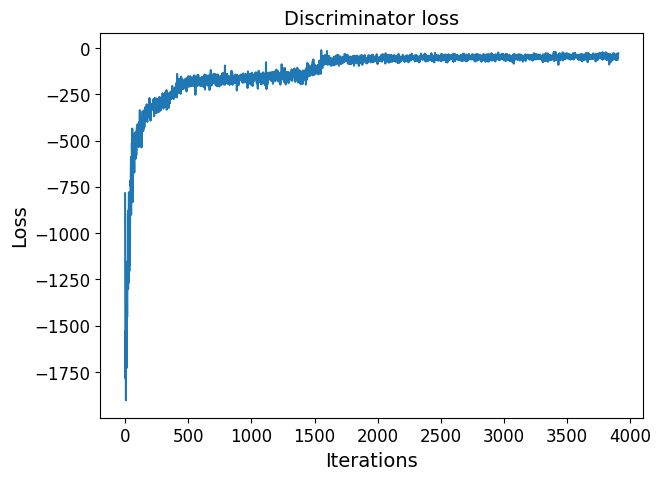

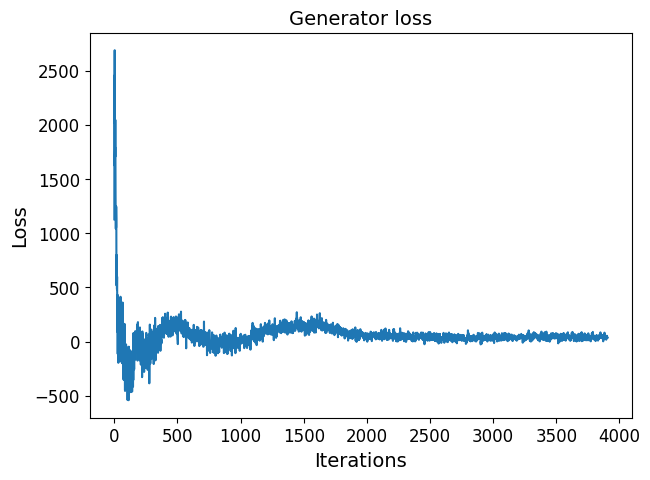

In [191]:
# ====
# choose these parameters (you have to train the model more than 20 epochs to get good results)
BATCH_SIZE = 16   # any adequate value
N_CHANNELS = 64   # > 32
N_EPOCHS = 20     # > 10
CRITIC_STEPS = 16 # > 2
GP_WEIGHT = 8    # > 5
LR = 3e-4           # < 1e-3
# ====

train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

generator = ConvGenerator(n_channels=N_CHANNELS)
critic = ConvCritic(n_channels=N_CHANNELS)

train_losses = train_wgan(
    generator, 
    critic, 
    train_loader,
    critic_steps=CRITIC_STEPS, 
    batch_size=BATCH_SIZE, 
    n_epochs=N_EPOCHS,
    lr=LR,
    gp_weight=GP_WEIGHT,
    use_cuda=USE_CUDA
)

plot_losses(train_losses['discriminator_losses'], 'Discriminator loss')
plot_losses(train_losses['generator_losses'], 'Generator loss')

Let sample from our model and draw the samples.

In [197]:
generator.eval()
critic.eval()
with torch.no_grad():
    samples = generator.sample(1000)
    samples = samples.cpu().detach().numpy()
    
samples = (samples + 1) /2
show_samples(samples[:100], title='CIFAR-10 WGAN-GP-generated samples')

RuntimeError: CUDA error: CUBLAS_STATUS_EXECUTION_FAILED when calling `cublasLtMatmul( ltHandle, computeDesc.descriptor(), &alpha_val, mat1_ptr, Adesc.descriptor(), mat2_ptr, Bdesc.descriptor(), &beta_val, result_ptr, Cdesc.descriptor(), result_ptr, Cdesc.descriptor(), &heuristicResult.algo, workspace.data_ptr(), workspaceSize, at::cuda::getCurrentCUDAStream())`

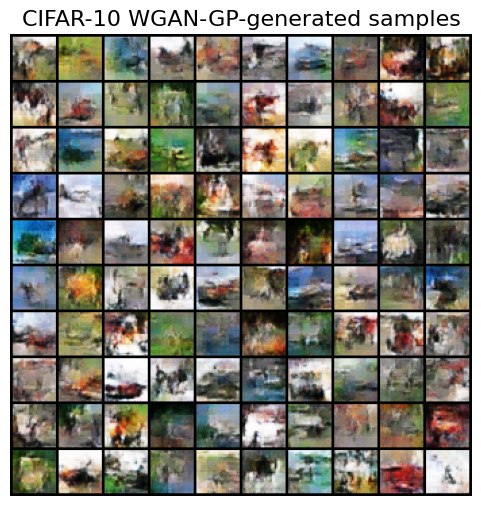

In [22]:
generator.eval()
critic.eval()
with torch.no_grad():
    samples = generator.sample(1000)
    samples = samples.cpu().detach().numpy()
    

show_samples(samples[:100], title='CIFAR-10 WGAN-GP-generated samples')

### Problem 3: SN-GAN on CIFAR10 (3pt)

[Spectral Normalization GAN](https://arxiv.org/pdf/1802.05957.pdf) replaces the weights in the critic $f(\mathbf{x}, \boldsymbol{\phi})$ by 
$$
    \mathbf{W}^{SN} = \frac{\mathbf{W}}{\|\mathbf{W}\|_2}.
$$

This ensures that $\| f\|_L \leq 1$.

Power iteration method allows to efficiently compute $\| \mathbf{W} \|_2 = \sqrt{\lambda_{\text{max}}(\mathbf{W}^T \mathbf{W})}$.
    
The pseudocode of the method is:
* $\mathbf{u}_0$ -- random vector.
* for $k = 0, \dots, n - 1$: 
$$
    \mathbf{v}_{k+1} = \frac{\mathbf{W}^T \mathbf{u}_{k}}{\| \mathbf{W}^T \mathbf{u}_{k} \|}, \quad \mathbf{u}_{k+1} = \frac{\mathbf{W} \mathbf{v}_{k+1}}{\| \mathbf{W} \mathbf{v}_{k+1} \|}.
$$
* approximate the spectral norm
$$
    \| \mathbf{W} \|_2 = \sqrt{\lambda_{\text{max}}(\mathbf{W}^T \mathbf{W})} \approx \mathbf{u}_{n}^T \mathbf{W} \mathbf{v}_{n}.
$$

First step is to implement this method.

In [42]:
COEF = 1

In [43]:
# https://github.com/niffler92/SNGAN/blob/1083365fa7a87b4ed64199107cd132475ed0d914/spectralnorm.py#L31


def power_iteration_method(W, n_iters, u_init=None, v_init=None):
    if u_init is None:
        u_init = nn.Parameter(torch.randn(W.shape[0]) / COEF, requires_grad=False)
    if v_init is None:
        v_init = nn.Parameter(torch.randn(W.shape[1]) / COEF, requires_grad=False)

    # ====
    # 1) implement for loop and update v_init/u_init
    # 2) calculate spectral norm
    # 3) return spectral norm (sigma) and the last values for v_init, u_init
    
    for i in range(n_iters):
        v_next = W.t() @ u_init
        v_next /= (v_next.norm(p=2) + 1e-12)
        u_next = W @ v_next
        u_next /= (u_next.norm(p=2) + 1e-12)
        u_init = u_next
        v_init = v_next
    
    sigma = (u_init.t() @ W @ v_init).data
    # ====
    return sigma, u_init, v_init


def test_power_iteration_method():
    W = np.array([
        [1, 2, 3],
        [2, 3, 4],
        [3, 4, 5],
        [3, 8, 1]
    ], dtype=np.float32)
    U, S, V = np.linalg.svd(W)
    W_tensor = torch.tensor(W)
    sigma, u, v = power_iteration_method(W_tensor, n_iters=10)
    np.allclose(S[0], sigma)
    np.allclose(u, U[:, 0])
    np.allclose(v, V[0, :])


test_power_iteration_method()

Now we need to define layers with Spectral Normalization (we will use `SpectralNormConv2D` and `SpectralNormLinear` layers instead of standard `nn.Conv2D` and `nn.Linear` in our critic).

In [44]:
class SpectralNormConv2D(nn.Conv2d):
    def __init__(self, *args, **kwargs):
        self.power_iterations = kwargs.pop("power_iterations")
        super().__init__(*args, **kwargs)
        self.u = nn.Parameter(torch.randn(self.weight.shape[0]) / COEF, requires_grad=False)
        self.v = nn.Parameter(torch.randn(self.weight.shape[1]) / COEF, requires_grad=False)
        
    def forward(self, input_):
        W = self.weight.view(self.weight.shape[0], -1)
        with torch.no_grad():
            # ====
            # apply power iteration method
            sigma, u, v = power_iteration_method(W, self.power_iterations, 
                                                           self.u.data, self.v.data)
            # ====
        self.u.data = u.data
        self.v.data = v.data
        self.weight.data = self.weight.data / sigma
        
        return super().forward(input_)


class SpectralNormLinear(nn.Linear):
    def __init__(self, *args, **kwargs):
        self.power_iterations = kwargs.pop("power_iterations")
        super().__init__(*args, **kwargs)
        
        self.u = nn.Parameter(torch.randn(self.weight.shape[0]) / COEF, requires_grad=False)
        self.v = nn.Parameter(torch.randn(self.weight.shape[1]) / COEF, requires_grad=False)
        
    def forward(self, input):
        W = self.weight.view(self.weight.shape[0], -1)
        with torch.no_grad():
            # ====
            # apply power iteration method
            sigma, u, v = power_iteration_method(W, self.power_iterations, 
                                                           self.u, self.v)
            # ====
        self.u.data = u.data
        self.v.data = v.data
        self.weight.data = self.weight.data / sigma
        
        return super().forward(input)

That is all :) 

We will use the same `ConvGenerator`, `ConvCritic` and `train_wgan()` as for WGAN model here.

Total number of epochs: 25


  0%|          | 0/25 [00:00<?, ?it/s]

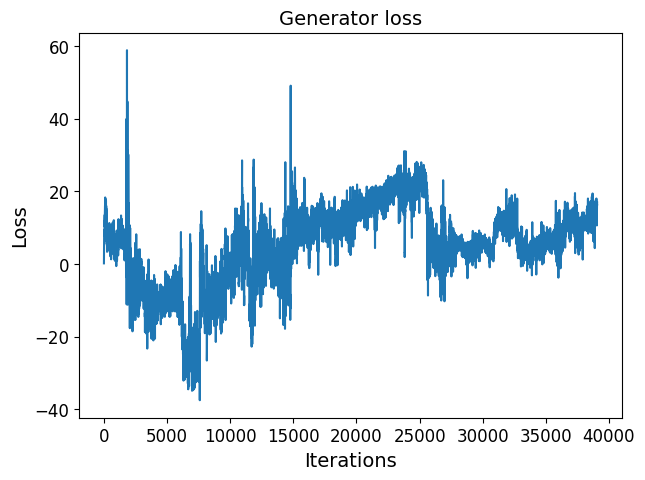

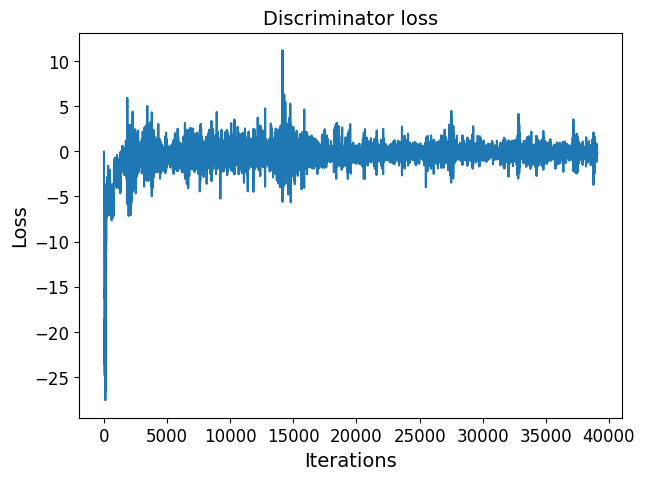

In [49]:
# ====
# choose these parameters
BATCH_SIZE = 16       # any adequate value
DIM = 32              # > 32
N_EPOCHS = 25         # > 20 
CRITIC_STEPS = 2     # 1 < x < 10
POWER_ITERATIONS = 2 # 1 < x < 5
LR = 3e-4               # < 1e-3
# ====

train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
print('Total number of epochs:', N_EPOCHS)

generator = ConvGenerator(n_channels=DIM)
conv_layer = partial(SpectralNormConv2D, power_iterations=POWER_ITERATIONS)
linear_layer = partial(SpectralNormLinear, power_iterations=POWER_ITERATIONS)
critic = ConvCritic(n_channels=DIM, conv_layer=conv_layer, linear_layer=linear_layer)

train_losses = train_wgan(
    generator, 
    critic, 
    train_loader,
    critic_steps=CRITIC_STEPS, 
    batch_size=BATCH_SIZE, 
    n_epochs=N_EPOCHS,
    lr=LR,
    use_cuda=USE_CUDA
)

g_losses = train_losses['generator_losses']
d_losses = train_losses['discriminator_losses']

plot_losses(g_losses, 'Generator loss')
plot_losses(d_losses, 'Discriminator loss')

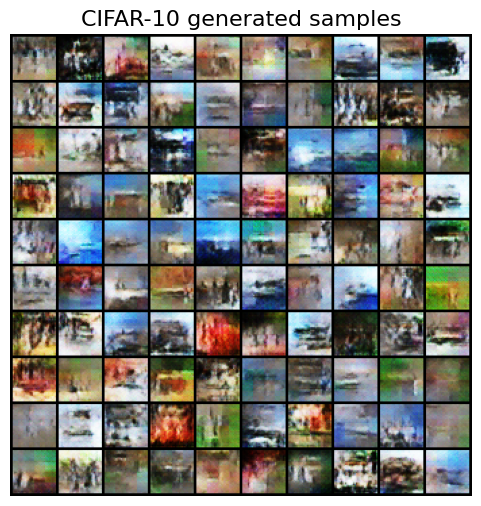

In [50]:
generator.eval()
critic.eval()
with torch.no_grad():
    samples = generator.sample(1000)
    samples = samples.cpu().detach().numpy()
    
samples = (samples + 1) / 2
show_samples(samples[:100], title='CIFAR-10 generated samples')

You are really welcome to experiment with combination of three approaches to get best samples :)